In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable, grad


# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=1000, shuffle=True)


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            # Tanh activation because MNIST is normalized between -1 and 1
            nn.Tanh()  
        )

    def forward(self, noise):
        img = self.model(noise)
        # Reshape to 2D image for MNIST
        img = img.view(img.size(0), 28, 28)  
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
            # No Sigmoid or Tanh at the output for WGAN-GP
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [4]:
LAMBDA = 10  # Penalty coefficient


def compute_gradient_penalty(D, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    # Ensure alpha is shaped correctly for broadcasting
    alpha = torch.rand(batch_size, 1, device=real_samples.device)
    alpha = alpha.expand(batch_size, real_samples.nelement() // batch_size).contiguous().view(batch_size, -1)

    # Ensure real_samples and fake_samples are flat
    real_samples_flat = real_samples.view(batch_size, -1)
    fake_samples_flat = fake_samples.view(batch_size, -1)

    # Calculate interpolates
    interpolates = (alpha * real_samples_flat + (1 - alpha) * fake_samples_flat).requires_grad_(True)
    d_interpolates = D(interpolates)
    
    fake = Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)  
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



    




In [5]:
# Instantiate the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the optimisers

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0, 0.9))



6. Training Loop

In [6]:
# Define variables to track progress
avg_d_loss = 0
avg_g_loss = 0
n_batches = len(data_loader)

# Define the number of critic updates per generator update
n_critic = 5  

for epoch in range(200):
    for i, (imgs, _) in enumerate(data_loader):
        
        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_critic):  # Update the discriminator n_critic times
            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.shape[0], 100)  # Ensure noise_dim matches generator input

            # Generate a batch of images
            fake_imgs = generator(z)

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            
            # Wasserstein GAN loss w/ gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty

            d_loss.backward()
            optimizer_D.step()
            avg_d_loss += d_loss.item() / n_critic  # Average over the n_critic updates
        
        # -----------------
        #  Train Generator
        # -----------------
        if i % n_critic == 0:  # Update the generator every n_critic steps
            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            g_loss = -torch.mean(discriminator(gen_imgs))

            g_loss.backward()
            optimizer_G.step()
            avg_g_loss += g_loss.item()

        # Prints progress within the epoch
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f"Epoch [{epoch+1}/{200}], Step [{i+1}/{n_batches}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    # Prints average loss per epoch
    avg_d_loss /= n_batches
    avg_g_loss /= n_batches
    print(f"Epoch [{epoch+1}/{200}] completed. Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
    # Resets average losses for the next epoch
    avg_d_loss = 0
    avg_g_loss = 0


Epoch [1/200] completed. Avg D Loss: -29.3478, Avg G Loss: -0.4783
Epoch [2/200] completed. Avg D Loss: -17.9089, Avg G Loss: -2.6249
Epoch [3/200] completed. Avg D Loss: -10.6262, Avg G Loss: -1.8176
Epoch [4/200] completed. Avg D Loss: -10.9072, Avg G Loss: -0.8422
Epoch [5/200] completed. Avg D Loss: -11.6281, Avg G Loss: -0.5435
Epoch [6/200] completed. Avg D Loss: -12.1119, Avg G Loss: -0.4076
Epoch [7/200] completed. Avg D Loss: -12.3806, Avg G Loss: -0.2939
Epoch [8/200] completed. Avg D Loss: -12.4709, Avg G Loss: -0.2984
Epoch [9/200] completed. Avg D Loss: -12.3474, Avg G Loss: -0.4094
Epoch [10/200] completed. Avg D Loss: -12.0548, Avg G Loss: -0.4676
Epoch [11/200] completed. Avg D Loss: -11.6393, Avg G Loss: -0.5522
Epoch [12/200] completed. Avg D Loss: -11.1634, Avg G Loss: -0.6852
Epoch [13/200] completed. Avg D Loss: -10.7003, Avg G Loss: -0.7523
Epoch [14/200] completed. Avg D Loss: -10.2039, Avg G Loss: -0.8471
Epoch [15/200] completed. Avg D Loss: -9.6854, Avg G Loss

KeyboardInterrupt: 

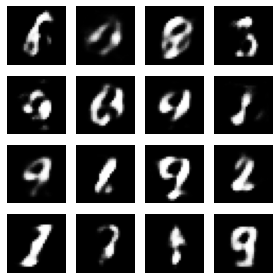

In [7]:
# Visualise generations

with torch.no_grad():
    test_noise = torch.randn(1000, 100)
    generated_images = generator(test_noise).view(-1, 28, 28).cpu().data.numpy()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# Path to save the model
MODEL_PATH = '/Users/sina/Downloads/SCRATCH_GENERATIVE_ADV_NET/Saved_Generator_States/generator_state_dict.pth'

# Save the generator's state dictionary
torch.save(generator.state_dict(), MODEL_PATH)

# # Instantiate the model
# generator = Generator()

# # Load the state dictionary
# generator.load_state_dict(torch.load(MODEL_PATH))

# # Set the model to evaluation mode if you are doing inference only
# generator.eval()

In [9]:
# Save the optimiser state
OPTIMIZER_PATH = '/Users/sina/Downloads/SCRATCH_GENERATIVE_ADV_NET/Saved_Optimiser_States/optimizer_G_state_dict.pth'
torch.save(optimizer_G.state_dict(), OPTIMIZER_PATH)

# To load the optimiser state, first instantiate the optimiser, then load the state dictionary
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.9))
optimizer_G.load_state_dict(torch.load(OPTIMIZER_PATH))
